In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YavuzSelim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from bs4 import BeautifulSoup # For HTML parsing
# import urllib2 # Website connections
from urllib.request import urlopen
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

In [3]:
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    try:
        site = urlopen(website).read() # Connect to the job posting
    except: 
        print("Error while opening web site")
        return   # Need this in case the website isn't there anymore or some other weird connection problem 
    
    soup_obj = BeautifulSoup(site) # Get the html from the site
    
    if len(soup_obj) == 0: # In case the default parser lxml doesn't work, try another one
        soup_obj = BeautifulSoup(site, 'html5lib')
    
    #print(soup_obj)
    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
    
    

    text = soup_obj.get_text() # Get the text from this

    

    lines = (line.strip() for line in text.splitlines()) # break into lines

    
    
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    

    text = ''.join(chunk for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line
    
    # Now clean out all of the unicode junk (this line works great!!!)
    
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception
   
    text = str(text)
    text = re.sub("[^a-zA-Z+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                             # Also include + for C++
    text = re.sub(r"([a-z])([A-Z])", r"\1 \2", text) # Fix spacing issue from merged words
    
    text = text.lower().split()  # Go to lower case and split them apart
    
    
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    text = [w for w in text if not w in stop_words]
    
    
    
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                           # or not on the website)
    
    return text

In [4]:
sample = text_cleaner('https://www.indeed.com/jobs?q=Data+Scientist&l=Washington%2C+DC')
sample[:20] # Just show the first 20 words


['data',
 'hands',
 'hour',
 'physics',
 'claims',
 'senior',
 'based',
 'knowledge',
 'help',
 'tools',
 'zeneca',
 'also',
 'organize',
 'algorithm',
 'working',
 'varelated',
 'consulting',
 'group',
 'create',
 'companies']

In [47]:
def skills_info(city = None, state = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
    
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
    #https://tr.indeed.com/jobs?q=data+scientist&l=Ankara
    final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        '''
        final_site_list = ['http://www.indeed.com/jobs?q=', final_job, '&l=', final_city,
                   '+', state] # Join all of our strings together so that indeed will search correctly
        '''
        final_site_list = ['https://tr.indeed.com/jobs?q=',final_job,'&l=', final_city]
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string
    print('Final_site:'+ final_site)

    base_url = 'http://www.indeed.com'


    try:
        html = urlopen(final_site).read() # Open up the front page of our search first
    except:
        print('That city/state combination did not have any jobs. Exiting . . .') # In case the city is invalid
        return
    soup = BeautifulSoup(html) # Get the html from the first page
    #print(soup)


    # Now find out how many jobs there were

    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
    print(str(num_jobs_area))                                            # The 'searchCount' object has this
    num_jobs_area = str(num_jobs_area)
    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    job_numbers = (job_numbers[1])
    total_num_jobs = (job_numbers)
    city_title = city
    if city is None:
        city_title = 'Nationwide'
    
    print ('There were '+str(total_num_jobs)+' jobs found,'+city_title) # Display how many jobs were found

    num_pages = int(total_num_jobs)/10 # This will be how we know the number of times we need to iterate over each new
                                  # search result page
    job_descriptions = [] # Store all our descriptions in this list
    print("Num pages: "+str(num_pages+1))
    for i in range(0,int(num_pages+1)): # Loop through all of our search result pages
        print ('Getting page'+ str(i))
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
        print('Current page'+ current_page)
        
        html_page = urlopen(current_page).read() # Get the page
        
        page_obj = BeautifulSoup(html_page) # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
        #print(job_link_area)
        
        job_URLS = [base_url + str(link.get('href')) for link in job_link_area.find_all('a')] # Get the URLS for the jobs
        
        job_URLS = list(filter(lambda x:'clk' in x, job_URLS)) # Now get just the job related URLS
        
        for j in range(0,len(job_URLS)):
            
            final_description = text_cleaner(job_URLS[j])
            #print(final_description)
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            #sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
    
    print ('Done with collecting the job postings!')    
    print ('There were'+str(len(job_descriptions))+ 'jobs successfully found.')


    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp

    # Now we can just look at our final dict list inside doc_frequency

    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for

    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                   'Ruby':doc_frequency['ruby'],
                  'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                  'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                  
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                      'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                      'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
               'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
               'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
               'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
               'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
               
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                 'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                 'MongoDB':doc_frequency['mongodb']})
                 
           
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects

    

    final_frame = pd.DataFrame(list(overall_total_skills.items()), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 

    # Change the values to reflect a percentage of the postings 

    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                  #  having that term 

    # Sort the data for plotting purposes

    #final_frame.sort(columns = 'NumPostings', ascending = False, inplace = True)
    final_frame.sort_values(by=['NumPostings'], ascending = False, inplace = True)
    # Get it ready for a bar plot
    
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                              title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
    
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
    
    
    return fig, final_frame # End of the function
    
    
    #'''
    '''
    if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
    else:
        total_num_jobs = int(job_numbers[2]) 
'''

Final_site:https://tr.indeed.com/jobs?q=data+scientist&l=Istanbul
b'\n        Sayfa 1 (toplam 15 i\xc5\x9f)'
There were 15 jobs found,Istanbul
Num pages: 2.5
Getting page0
Current pagehttps://tr.indeed.com/jobs?q=data+scientist&l=Istanbul&start=0
Getting page1
Current pagehttps://tr.indeed.com/jobs?q=data+scientist&l=Istanbul&start=10
Done with collecting the job postings!
There were15jobs successfully found.


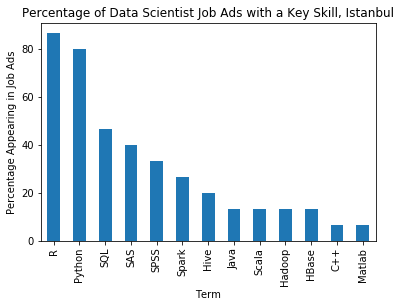

In [48]:
seattle_info = skills_info(city = 'Istanbul')

Final_site:https://tr.indeed.com/jobs?q=data+scientist&l=Ankara
b'\n        Sayfa 1 (toplam 1 i\xc5\x9f)'
There were 1 jobs found,Ankara
Num pages: 1.1
Getting page0
Current pagehttps://tr.indeed.com/jobs?q=data+scientist&l=Ankara&start=0
Done with collecting the job postings!
There were2jobs successfully found.


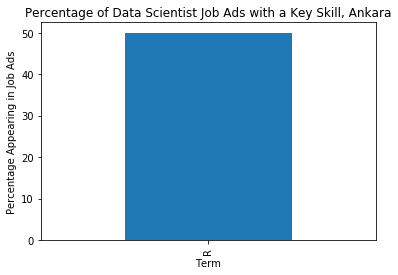

In [42]:
seattle_info = skills_info(city = 'Ankara')

In [44]:
seattle_info = skills_info(city = 'İzmir')

Final_site:https://tr.indeed.com/jobs?q=data+scientist&l=İzmir
That city/state combination did not have any jobs. Exiting . . .
